In [1]:
using Surrogates,Flux,Statistics,DifferentialEquations,Plots,Suppressor,MLDataUtils

In [2]:
lb=Float32[0.0,5.0]
ub=Float32[30.0,10.0]

2-element Vector{Float32}:
 30.0
 10.0

In [3]:
#Define scaler functions to preprocess data
vecscaler(x)=(x.-lb)./(ub.-lb)
scaler(x)= ((x[1]- lb[1])/(ub[1]-lb[1]),(x[2]- lb[2])/(ub[2]-lb[2]))
invscaler(x_sc)=(x_sc[1]*(ub[1]-lb[1]) + lb[1],x_sc[2]*(ub[2]-lb[2]) + lb[2])
output_scaler(x)= x ./ 2
inv_output_scaler(x)=x.*2

inv_output_scaler (generic function with 1 method)

In [4]:
function DEX_Lpt(dose)
    return Lpt = 1.131e-06 - dose*(dose*(dose*(dose*((6.23e-13*dose) + 5.96e-11) - 5.61e-09) + 1.272e-07) - 8.797e-07)
end

function DEX_Kt(dose)
    return Kt = dose*(dose*(dose*(dose*((1.139e-11*dose) - 8.389e-10) + 2.183e-08) - 2.421e-07) + 1.093e-06) + 3.798e-07
end

function Diffusion(rs)
    Diam_parc = 2*rs
    return D = 1.981e-06*Diam_parc^(-1.157) + 2.221e-08
end

function Blood_half_life(rs)
    Diam_parc = 2*rs
    a1 = 1081
    b1 = -16.63
    c1 = 84.82
    a2 = 517.4
    b2 = 65.61
    c2 = 996.6
    return kd = (a1*exp(-((Diam_parc-b1)/c1)^2) + a2*exp(-((Diam_parc-b2)/c2)^2))*60
end
function sumseries(term,start,stop)
    sum = 0
    for i=start:stop
        sum += term(i)
    end
    return sum
end
function soluteperm(Lpt,rs)
    #calculate diffusion constant from Stoke's Einstein equation
    kB = 1.380648*10^(-23)       # Boltzmann Constant (J/K)
    T = 310.15                   # Temperature K
    eta = 3*10^(-5)              # viscosity of blood (mmHg-sec)
    conv_mu  = 133.322365        # (Pascal/mmHg)
    etac = eta*conv_mu            # Pascal-sec
    pore_conv = 10^(-9)          #(m/nm)
    r_partc = rs*pore_conv       #radius (m)
    D0 = kB*T/(6*pi*etac*r_partc)*1e4 # Diffusivity (cm^2/s)

    #Bungay and Brenne Hydrodynamic coefficients for cylindrical pore modal
    a_k= [-73/60,77293/50400,-22.5083,-5.6117,-.3363,-1.216,1.647]
    b_k= [7/60,-2227/50400,4.0180,-3.9788,-1.9215,4.392,5.006]

    #Additional constants
    gamma = 1e-3 #fraction of vascular surface area occupie by pores
    eta = 3e-5  #Blood viscosity (mmHg/s)
    L = 5e-4    # Vessel wall thickness (cm)
    r_pore = sqrt(8*eta*L*Lpt/gamma)*1e7 # vessel radius of pore in nm
    lambda = rs/r_pore # ratio of diffusing marcomolecule radius to pore radisu

    #Calculate ratio of K_t & K_s factors
    prefactor= (9/4)*pi^2*(sqrt(2))*((1-lambda)^-2.5) # use for calculation of kt &ks
    K_t = prefactor*(1+sumseries((i->a_k[i]*(1-lambda)^i),1,2))+ sumseries(i->(a_k[i+3])*lambda^i,0,4)
    K_s= prefactor*(1+sumseries((i->b_k[i]*(1-lambda)^i),1,2))+ sumseries(i->(b_k[i+3])*lambda^i,0,4)

    #calculate remaining constants
    Phi = (1-lambda)^2 #partition coefficient
    H=6*pi*Phi/K_t #diffusive hindrance factor
    W= Phi*(2-Phi)*K_s/(2*K_t) #convective hindrance factor
    Perm= gamma*H*D0/L #Vascular permeability
    sigma=1-W #solute reflection coefficient
    return Perm, sigma
end

function a_pressure(r,α)
    return r == 0 ? 1 - csch(α) : 1 - sinh(α*r)/(r*sinh(α))
    #return 1 - sinh(α*r)/(r*sinh(α))
end

function a_pressure_prime(r,α)
    return r == 0 ? 0 : (sinh(α*r)-α*r*cosh(r*α))/(sinh(α)*r^2)
    #return (sinh(α*r)-α*r*cosh(r*α))/(sinh(α)*r^2)
end

function MSTHighPeclet!(dc,c,p,t)
    #dc = preallocated vector corresponding to f(c,t)= dC/dt
    #c = concentration vector at all spatial points
    #p = vector of parameters as define in modelanalysis
    #t = current time
    #Unpackage parameters
    P,N,sigma,Perm,Lpt,Svt,Kt,Pvv,Pv,D,r,dr,kd=p
    co=1 #initial concentration
    tspan=3600 #timespan
    cv=co*exp(-t*tspan/kd) #time-dependent exponential decay term
    Pe=Lpt*Pv*(Pvv-P[1])*(1-sigma)/Perm #Initial Peclet value
    #interior boundary condition
    dc[1]=tspan*(2*D*(c[2]-c[1])/dr^2 +Lpt*Svt*Pv*(Pvv-P[1])*(1-sigma)*cv)
    for j=2:N-1
        dc[j]=tspan*(((2*D/r[j])*((c[j+1]-c[j])/dr))+(D*(c[j+1]-2*c[j]+c[j-1])/dr^2)+ Kt*((P[j+1]-P[j-1])/(2*dr))*((c[j+1]-c[j])/dr)+ Lpt*Svt*Pv*(Pvv-P[j])*(1-sigma)*cv)
    end
    dc[N]=0 # concentration at the outtermost boundary
end

function Accumulation_Model(sol,n_spatial,n_time,n_nodes)
    c_model=zeros(n_nodes)
    spacingfactor = n_time ÷ n_nodes
    for j=1:n_nodes
        c_model[j]=mean(sol[:,spacingfactor*j])
    end
    return c_model[end]
end

function accumlation_intermediate(x) #x is a vector containing Dose and Radius\
    dose,rs=x
    n_spatial=100
    n_time=21
    n_nodes = 21 # number of nodes desired to be outputted for accumulation data
    Lpt,Kt = DEX_Lpt(dose),DEX_Kt(dose)
    Svt = 200;      #tumor vascular density
    D = Diffusion(rs);  #solute diffusion coefficient
    Perm,sigma=soluteperm(Lpt,rs) #Vascular permeability and solute reflection coefficient respectively
    R=1. # Tumor Radius
    Pv=25. #
    Pvv=1.
    kd=Blood_half_life(rs) # blood circulation time of drug in hours;
    att=R*sqrt(Lpt*Svt/Kt) #parameter alpha for tumor, ignoring lymphatics
    Press(r)= a_pressure(r,att)
    co=1.
    tdomain=300

    r= (1/R)*(range(0,stop=R,length=n_spatial))
    dr=1/(n_spatial-1)

    P= broadcast(Press,r)

    c0=zeros(n_spatial,1)
    c0[end]=0.
    #define timespan
    time_end =(300/3600)
    tspan=(0.,time_end)
    #package parameters
    p=P,n_spatial,sigma,Perm,Lpt,Svt,Kt,Pvv,Pv,D,r,dr,kd
    #Define and solve system of ODEs using time constant of 1/n_nodes and the QNDF solver for stiff systems
    dt=time_end/(n_time-1)
    #t = dt*[i for i=0:n_nodes-1]
    prob=ODEProblem(MSTHighPeclet!,c0,tspan,p)
    sol= solve(prob,QNDF(),saveat=dt)
    return sol[99,1,end]
end
accum(x) =  output_scaler(accumlation_intermediate(invscaler(x)))

accum (generic function with 1 method)

In [5]:
#Specify number of samples to generate and perform 70:30 split for data generation
n_samp=Int64(1e6);
n_train =Int64(n_samp*.7);
n_test = Int64(n_samp*.3);

In [6]:
#Create Data Sets
X=Float32.(reshape([x[j] for x in scaler.(sample(n_samp, lb,ub, SobolSample())) for j in eachindex(x)],(2,n_samp)));
Y=reshape([Float32.(y[j]) for y in [accum(col) for col in eachcol(X)] for j in eachindex(y)],(1,n_samp));

In [7]:
#Shuffle and Split data;
Xs,Ys=shuffleobs((X, Y));
(x_train, y_train), (x_test, y_test) = splitobs((Xs, Ys); at = 0.7);
#package data
using Flux.Data: DataLoader
bsize = n_train ÷ 10
data_mb = DataLoader((x_train,y_train),batchsize=bsize,shuffle=true);
data = DataLoader((x_train,y_train));

In [8]:
#Specify Neural Network Structure
n=8
activation_func=Flux.tanh
NN_peak = Chain(Dense(2,n),Dense(n,n,activation_func),Dense(n,n,activation_func),Dense(n,1))
loss(x,y) = Flux.mse(NN_peak(x),y)
learning_rate = 5e-4
optimizer = ADAM(learning_rate)
n_epochs = 50;
ps = Flux.params(NN_peak);
ϵ=1e-7;

In [9]:
Flux.train!(loss, ps, data, optimizer)
Flux.train!(loss, ps, data, optimizer)
@show loss(x_train,y_train)

for i=1:n_epochs
    Flux.train!(loss, ps, data_mb, optimizer)
    l=loss(x_train,y_train)
    #epoch_l[i]=l
    @show(i,l)
    if l < ϵ
        break
    end
end

loss(x_train, y_train) = 3.816073f-5
i = 1
l = 5.0891267f-5
i = 2
l = 2.4135652f-5
i = 3
l = 2.4472067f-5
i = 4
l = 2.048134f-5
i = 5
l = 2.0026877f-5
i = 6
l = 1.9159903f-5
i = 7
l = 1.8881108f-5
i = 8
l = 1.8636463f-5
i = 9
l = 1.8475723f-5
i = 10
l = 1.8339384f-5
i = 11
l = 1.8226454f-5
i = 12
l = 1.8126275f-5
i = 13
l = 1.8036484f-5
i = 14
l = 1.795565f-5
i = 15
l = 1.7881406f-5
i = 16
l = 1.7813449f-5
i = 17
l = 1.7750706f-5
i = 18
l = 1.769178f-5
i = 19
l = 1.7636794f-5
i = 20
l = 1.7585218f-5
i = 21
l = 1.753642f-5
i = 22
l = 1.7490276f-5
i = 23
l = 1.7446382f-5
i = 24
l = 1.7404642f-5
i = 25
l = 1.7364688f-5
i = 26
l = 1.7326644f-5
i = 27
l = 1.7290029f-5
i = 28
l = 1.7255064f-5
i = 29
l = 1.722135f-5
i = 30
l = 1.7188875f-5
i = 31
l = 1.7157683f-5
i = 32
l = 1.7127632f-5
i = 33
l = 1.709861f-5
i = 34
l = 1.7070539f-5
i = 35
l = 1.7043301f-5
i = 36
l = 1.7017048f-5
i = 37
l = 1.6991644f-5
i = 38
l = 1.696687f-5
i = 39
l = 1.6943004f-5
i = 40
l = 1.6919716f-5
i = 41
l = 1.689725

In [10]:
@show loss(x_test,y_test)

loss(x_test, y_test) = 1.6703958f-5


1.6703958f-5

In [11]:
NN_model(x)=inv_output_scaler(NN_peak(vecscaler(x)))

NN_model (generic function with 1 method)

In [12]:
NN_model(lb)

1-element Vector{Float32}:
 1.1417373

In [13]:
#Estimate Percent Error between ANN model and mechanistic model
#Must ignore first element because of divide by 0 error
y_test_inv_scaled= inv_output_scaler(y_test)
y_test_mod = inv_output_scaler(NN_peak(x_test))
percent_diff(orig,new) = orig == 0 ? NaN : abs((orig-new)/orig)*100
error_mat =percent_diff.(y_test_inv_scaled,y_test_mod)
mean_error = mean(error_mat);
std_error = std(error_mat);
@show mean_error;
@show std_error;

mean_error = 0.27898848f0
std_error = 0.26429835f0


In [14]:
function mean_error_func(x)
    orig = accumlation_intermediate(x)
    new = NN_model(x)[1]
    return percent_diff(orig,new)
end

mean_error_func (generic function with 1 method)

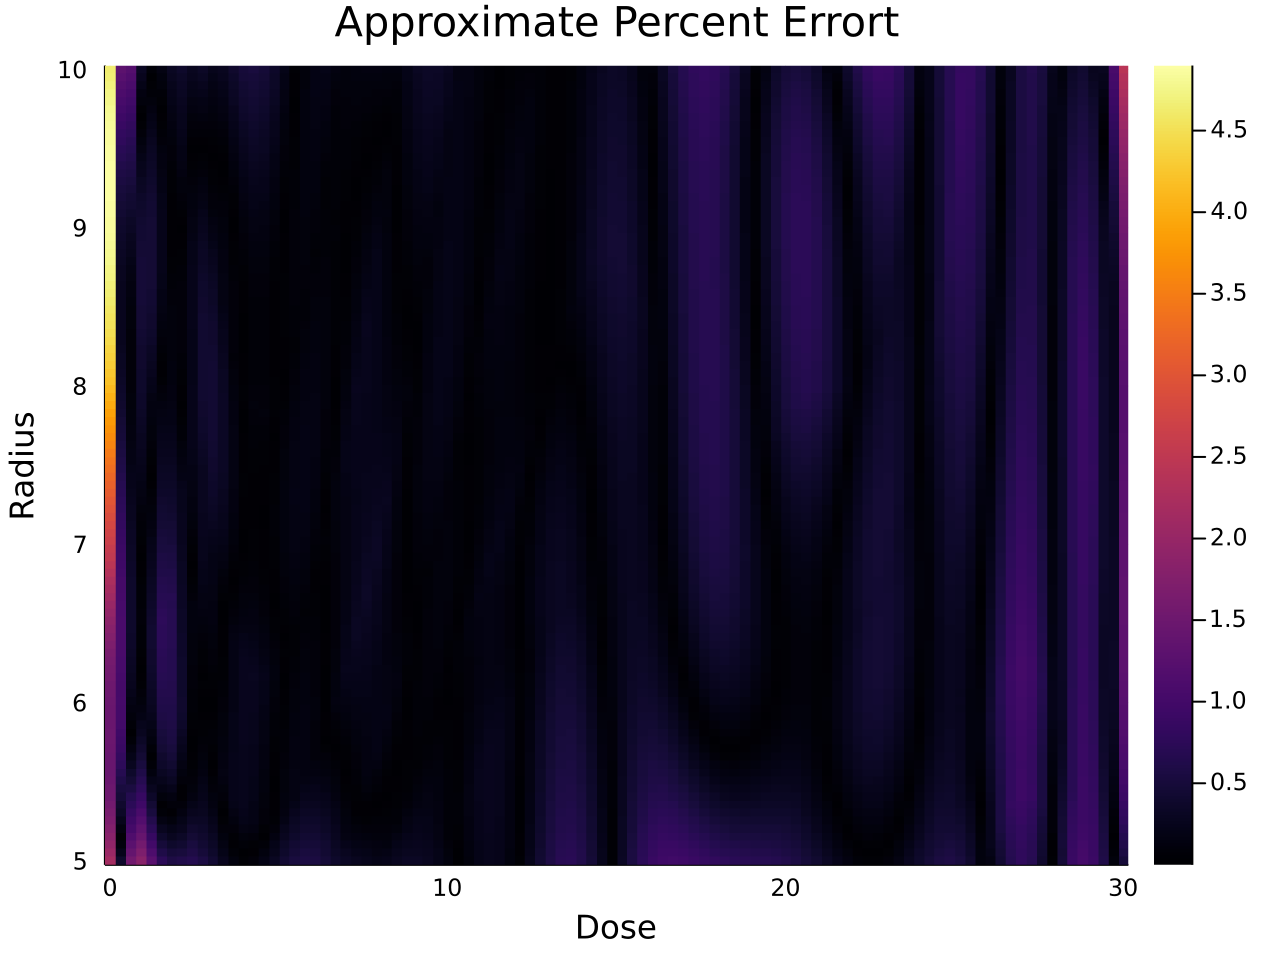

In [15]:
n_points = 100
dose_d=range(lb[1], ub[1], length=n_points)
rs_d= range(lb[2], ub[2], length=n_points)
err = reshape([mean_error_func([d,r]) for d in dose_d for r in rs_d],(n_points,n_points))

scale_factor =1
errplot = plot(dose_d,rs_d, err,title = "Approximate Percent Errort",
xlabel="Dose",
ylabel="Radius",
linetype=:heatmap,
size = (640*scale_factor,480*scale_factor),
dpi=200
);
display(errplot)

In [16]:
using BSON: @save
@save "P:\\TherapyDrugDesign\\cpeak.bson" NN_peak

cpeak (generic function with 1 method)

In [20]:
cpeak(lb)

1.1360936500033925

In [21]:
accumlation_intermediate(lb)

1.1177033705474464